In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import pandas as pd

Let's begin our practice by fitting a linear regression model using the linear algebra formula we derived in class: $\beta^* = (X^TX)^{-1}X^Ty$. We'll compare the result we get with sklearns linear regression implementation.

I'm going to define some fake data first. For the X matrix, I will randomly sample two columns from the standard normal distribution as my input variables, and then I will add a column of ones, $x_0$, which will allow me to fit an intercept in my linear model. For the y variable, I am going to define y as $3x_1 - x_2 + 7 + \epsilon$, where $x_1$ and $x_2$ are the two standard normal columns from my X matrix and $\epsilon$ is the normally distributed error that a linear model is assumed to have. Thus, the optimal $\beta$ values we should get are $\beta_1, \beta_2, \beta_0 = 3, -1, 7$. Note that $\beta_0$ is the intercept that we are learning, so we expect to get a value of 7.

If that explanation wasn't clear, don't worry about it. The short version of that previous paragraph is that I defined fake data and we are going to do linear regression on it.

In [ ]:
#define some practice data
np.random.seed(42)
x1 = np.random.normal(size = 100)
x2 = np.random.normal(size = 100)
x0 = np.ones(100)
X = np.vstack((x0, x1, x2)).T

y = 3 * x1 - x2 + 7 + np.random.normal(scale = 0.5, size = 100) #note we have to add the 0 mean normally distributed noise due to the N and E assumptions of L.I.N.E.

Now we can do some linear regression. First let's learn the coefficients according to our formula from class: $\beta^* = (X^TX)^{-1}X^Ty$. Observe that I calcluate the matrix inverse using numpy's implementation

```
np.linalg.inv
```



In [ ]:
#calculate the optimal regression coefficients
betas = np.linalg.inv(X.T @ X) @ X.T @ y
betas

You should get values of beta that are close to [7, 3, -1] by definition of the model.

In [ ]:
#compare with sklearn. Note since I included a column of 1's in my data, I initialize the sklearn model with fit_intercept = False. I've already set up the data to automatically fit an intercept.
#If you don't add a column of 1's to your dataset, you won't automatically fit an intercept, so you should keep fit_intercept = True, which is the default option in sklearn
lm = LinearRegression(fit_intercept = False).fit(X, y)

#we can see the coefficients we learned with lm.coef_
lm.coef_

Looks like we get the same regression coefficients using either the formula from class or sklearn's implementation. That's a good sign!

In [ ]:
#plot the model and the data
plt.plot(X@betas, y, 'k.')
plt.plot(X@betas, X@betas, 'r-')
plt.xlabel('Regression Model Predictions')
plt.ylabel('Actual Values')
plt.show()

**Testing the Linearity assumption, and multicollinearity**

Note, we went out of order here. You should test these things ***before*** you fit the model, but this is just a practice notebook, so we don't care about the order right now.

In [ ]:
#we can test for linearity and multicollinearity of the input variables at the same time using a seaborn pairplot and correlation matrix
df = pd.DataFrame(X, columns = ['x0', 'x1', 'x2'])
df['y'] = y
sns.pairplot(data = df[['x1', 'x2', 'y']])
plt.show()

In [ ]:
df[['x1', 'x2', 'y']].corr()

Based on the plots, I would say that x1 and y are strongly correlated, so I would conclude that x1 should go in the model. I would conclude that x2 and y are moderately correlated, so x2 should go in the model as well. Finally, there doesn't appear to be strong correlation between x1 and x2, so I am not worried about multicollinearity.

The correlation matrix backs up my conclusions from the plot. x1 and y are very strongly correlated with a correlation of 0.94. x2 and y are also moderately correlated with a correlation of -0.42. So both of those variables could justifiably be added to the linear regression model. Finally, the correlation between x1 and x2 is just -0.14, which is pretty week, so I'm not worried about multicollinearity.

**Danger ahead!!**

In the next cell, I show the true problem with having multicollinearity in a linear regression model. I define a new X matrix with a third column that is a scalar multiple of $x_1$, meaning I have perfect multicollinearity and $X^TX$ is not invertible. Let's see what happens

In [ ]:
#define the new column
x3 = 2 * x1

new_X = np.hstack((X, x3.reshape((-1,1))))

#now what happens when I try to solve for the regression coefficients
new_betas = np.linalg.inv(new_X.T @ new_X) @ new_X.T @ y

You should have gotten an error "Singular matrix" when you ran the previous cell. That's because $X^TX$ is not invertible in that code cell because of the multicollinearity between $x_1$ and $x_3$. A singular matrix is just another way to say a non-invertible matrix.

In the next cell, we see how sklearn's linear regression implementation deals with perfect multicollinearity

In [ ]:
lm = LinearRegression(fit_intercept = False).fit(new_X, y)

#we can see the coefficients we learned with lm.coef_
lm.coef_

Why did that work? It shouldn't have right? Remember in class we learned that the problem with perfect multicollinearity is that there is no unique solution to minimize the least squares loss function. In the case of a non invertible matrix, there are multiple possible solutions. Rather than raising an error that says "Hey dummy your data is multicollinear. You should use more data science feel!" sklearn instead just chooses one of the possible solutions. In particular, it chooses the solution that has smallest two norm according to the documentation here https://numpy.org/doc/2.1/reference/generated/numpy.linalg.lstsq.html

**That is why it is so important to have data science feel!** A bad data scientist will take a bunch of multicollinear input variables and feed it into sklearn's linear regression model and they think they have done something valuable and impressive because sklearn succesfully fits a model without raising any errors. We know better! We understand the problem of multicollinearity, so we will never make the mistake of feeding two highly correlated input variables into the same regression model!

In [ ]:
np.linalg.solve(new_X.T @ new_X, new_X.T @ y)

**Verifying Independence**

The next letter in our L.I.N.E. acronym is I, which stands for independence. Unfortunately, I'm not sure of a good way to test for independence. I was taught to just use some feel to deside if you think the errors are independent.

In the case of this problem, I defined the data by drawing independent samples from normal distributions and adding independently sampled noise from another normal distribution, so I know for a fact that the independence assumption has been met.

Consider another famous dataset that we have seen in this class, the iris dataset, which is a dataset containing measurements of petals and sepals on different classes of irises. Is there any reason to think that the length of petals on one iris would effect the length of petals on another iris? Probably not, so we can probably assume independence. However, suppose that if one type of iris is planted near another, it somehow dominates the other one by taking all the soil nutrients or all the sunlight or something. That would mean that the measurements of the big dominate iris and the weak dominated iris are not independent of each other in that case, so the independence assumption doesn't hold. That's the type of thinking I would say you need to do when trying to verify the independence assumption.

**Normality Assumption**

The next assumption we need to verify is are the residuals (errors) of our regression model normally distributed. Just like we learned when we learnd about EDA, a good way to asses the shape of a distribution is with some type of distribution plot like a histogram or KDE

In [ ]:
#get the residuals

resid = y - X @ betas
plt.hist(resid, bins = 10, density = True)
plt.show()

That looks fairly normal to me, so I would say we pass the normality assumption. IF I want to be more thorough I could use a statistical test like the shapiro-wilk test or the jarque-bera test (google those if you are curious), but for this practice notebook I think the above histogram is good enough.

**Equal Variance Assumption**

As we saw in the class slides, the best way that I know of to test equal variance is with a residual versus fitted values plot. What we want to see is that the points are randomly distributed around the center line and they don't get further or closer to the line as the fitted values increase. We can create those plots with seaborn, or we can do it manually

In [ ]:
#doing it manually
plt.plot(X@betas, resid, 'k.')
plt.axhline(y=0, color = 'red')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

In [ ]:
#with seaborn
sns.residplot(x = X@betas, y = df.y.values)
plt.show()

I would make the claim that the above plot(s) support the equal variance assumption. Thus we have passed all the required L.I.N.E. assumptions and the multicollinearity assumption!

## **Bonus Useful Material**




### Dealing with categorical variables

It is possible to incorporate categorical variables into a linear model but we need to convert them into numbers because we need to be able to multiply their values by slopes. The way to do that is by "encoding" them. There are lots of ways to encode categorical variables, but I recommend a method called one hot encoding. One hot encoding creates a new column for each category where 1 means the category is present and 0 means it isn't. For example, if I were to one hot encode a variable that describes if an animal is a cat or a dog, then I would end up with two new columns is_cat and is_dog. Note, you shouldn't include both of those columns in your training data though because if is_dog is 1 then we know is_cat is 0, so including both columns is unnecessary. In general when you one hot encode $n$ categories, you should only keep $n-1$ of the resulting columns in your training data.

In the following cell, I show how you can one hot encode data in pandas. Specifically, I one hot encode a pitcher handedness column, which I frequently have to do at work.

In [ ]:
fake_data = pd.DataFrame({'pitcher_id': [1,2,3,4,5,6,7,8,9],
    'pitcher_throws': ['R', 'R', 'L', 'L', 'R', 'R', 'L', 'R', 'L']})

#one hot encode the pitcher_throws column
pit_hand = pd.get_dummies(fake_data['pitcher_throws'], drop_first = False, dtype = int)
pit_hand

In [ ]:
#now I just choose one of the one hot encoded columns to include in my final dataset, and I can go ahead and drop the unencoded column if I want to

#add the encoded column to the dataset
fake_data['pit_hand_R'] = pit_hand['R'].values
fake_data

In [ ]:
#drop the unencoded column from the original data (optional)
fake_data.drop(columns = ['pitcher_throws'], inplace = True)
fake_data

### Feature Engineering nonlinearities

In the following cell, I generate two very nonlinear datasets. In the first, I sample x values from the standard normal distribution then define y as $x^2 + \epsilon$, where $\epsilon$ is normally distribued error. In the second, I again sample x values from a uniform distribution then define y as $\text{cos}(x) + \epsilon$.

In [ ]:
#dataset 1
x = np.random.normal(size = 100)
y = x**2 + np.random.normal(scale = 0.5, size = 100)

#plot x and y with a linear regression curve
sns.regplot(x= x, y = y)
plt.show()

Clearly, the L assumption in L.I.N.E. is not met in this dataset, and the resulting linear regression model does not fit the data well. However, ***that does not mean that we can't/shouldn't fit a linear regression model!*** It just means that we need to feature engineer the nonlinearity. In the following cell, I again feature engineer a new input variable x2, which I define simply by squaring x. Then I fit the linear regression model to x2 and y instead of x and y.

In [ ]:
lm =LinearRegression().fit(x.reshape((-1,1))**2, y.reshape((-1,1)))

plt.plot(x, y, 'k.', label = 'data')
xpoints = np.linspace(np.min(x), np.max(x))
plt.plot(xpoints, lm.predict(xpoints.reshape((-1,1))**2), 'r-', label = 'regression curve')
plt.legend()
plt.show()

In the previous cell, I just performed polynomial regression, but it's really just linear regression with a feature engineered $x^2$ input variable. In the following cell I show that what I did was feature engineer a linear relationship. You can see that there is a strong linear relationship between x**2 and y.

In [ ]:
plt.plot(x**2, y, 'k.')
plt.xlabel('x**2')
plt.ylabel('y')
plt.show()
print('correlation: ' + str(np.corrcoef(x**2, y)[0,1]))

Next, I move on to the second dataset where y is defined as a function of cos(x)

In [ ]:
#dataset 2
x = np.random.uniform(-2*np.pi, 2*np.pi, size = 100)
y = np.cos(x) + np.random.normal(scale = 0.3, size = 100)

#plot x and y with a linear regression curve
sns.regplot(x= x, y = y)
plt.show()

Once again, it is clear that our data does not pass the L test in the L.I.N.E. acronym, but again that does not mean we can't do linear regression, it just means we need to feature engineer the linear relationship. This time, I do that by defining a new variable which is the cosine of x

In [ ]:
lm =LinearRegression().fit(np.cos(x).reshape((-1,1)), y.reshape((-1,1)))

plt.plot(x, y, 'k.', label = 'data')
xpoints = np.linspace(np.min(x), np.max(x))
plt.plot(xpoints, lm.predict(np.cos(xpoints).reshape((-1,1))), 'r-', label = 'regression curve')
plt.legend()
plt.show()

In [ ]:
plt.plot(np.cos(x), y, 'k.')
plt.xlabel('cos(x)')
plt.ylabel('y')
plt.show()
print('correlation: ' + str(np.corrcoef(np.cos(x), y)[0,1]))

**Takeaway**

The thing that I want you to take away from the previous two examples is that just because the L assumption is not initially met in your data does not mean that you can't or even that you shouldn't perform linear regression. It just means that you need to do some feature engineering to create a linear relationship. In the previous cell you can see that I feature engineered a really strong linear relationship by taking the cosine of x, and then I was able to learn a really good linear regression model.

Some tips for feature engineering nonlinearities:


*   If the scatter plot looks wavy, consider sine or cosine
*   If the scatter plot seems to change direction n times, consider adding features $x^2, x^3, \ldots, x^n, x^{n+1}$. In other words, engineer a polynomial with max degree 1 higher than the number of changes of direction. For example, a parabola changes direction 1 time, and we know that we can fit parabolas well with $x^2 = x^{1 + 1}$
* If the scatter plot seems to plateau as x increases, consider using log(x) or sqrt(x), although be careful because neither of those functions can take negative values, so if your data is negative you need to think of something else
* If the scatter plot decays, you can try exponential decay np.exp(-x)

One of the downsides of linear modeling is that you have to manually do all this feature engineering, whereas decision trees and ensembles built with decision trees and neural networks automatically figure all this out for you. That's why despite their simplicity, linear modeling often requires the most effort and data science feel to get it right. It can be worth the extra effort though because linear models are more easily interpreted and explained than those other types of models.



### Feature Engineering Interactions

The idea behind interaction terms is that the effect that one variable has on the output depends on another variable. For example, suppose that I have an anxiety medication, and when I compare its effectiveness between males and females, I see that the reduction in anxiety as a function of dosage level is greater for females than it is for men:
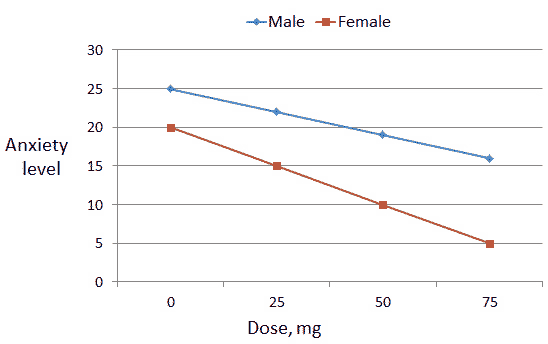

That suggests that I need an interaction term between my one hot encoded sex variable and the dosage variable because the effect that dosage has on anxiety depends on the sex of the patient.

The good news is that feature engineering interactions is extremely easy. All you have to do is create a new variable that is the product of the two variables of interest. So in the previous anxiety medication example, I would create a new variable that is the prodcut of dosage and is_male or is_female. If you have more questions about why that works, feel free to ask me, but think about it in the context of a linear regression model and you may gain some intuition on your own.

Unfortunately, just like feature engineering nonlinearities, we have to feature engineer all necessary interactions in linear models but we don't have to in tree based models or neural networks. Those types of models figure out the interactions for us automatically. Again, that is why linear modeling requires more thoughtfulness and EDA and effort than other types of modeling, but it can often be worth that extra effort!